# Yolo Detection 구현 : bus / trcuk detection

## 데이터셋 구축

### 캐글 데이터 받아오기

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.utils import make_grid

import torchvision.transforms as transforms
import os
import numpy as np
import pandas as pd
import utils
import matplotlib.pyplot as plt
import cv2
import json
import random
import albumentations as A
import shutil

from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from time import time
from ipywidgets import interact
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
!pip install kaggle --upgrade

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seonyong","key":"15cdbf608ae7dcc43e31d8ac3e790795"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!mkdir data/
%cd data

/content/data


In [6]:
!kaggle datasets download -d sixhky/open-images-bus-trucks

100% 365M/367M [00:16<00:00, 22.7MB/s]
100% 367M/367M [00:16<00:00, 23.1MB/s]


In [7]:
!unzip -qq '/content/data/open-images-bus-trucks.zip'

### 데이터 확인

In [8]:
data_dir  = '/content/data/images'

In [9]:
# 데이터 전체 수
data_len = os.listdir(data_dir + '/images')
len(data_len)

15225

In [10]:
# x, y 좌표는 정규화 -> 원래 좌표 필요 -> yolo 포멧 맞추기
df = pd.read_csv('/content/data/df.csv')
df = df.loc[:, ['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,0000599864fd15b3,Bus,0.343750,0.908750,0.156162,0.650047
1,00006bdb1eb5cd74,Truck,0.276667,0.697500,0.141604,0.437343
2,00006bdb1eb5cd74,Truck,0.702500,0.999167,0.204261,0.409774
3,00010bf498b64bab,Bus,0.156250,0.371250,0.269188,0.705228
4,00013f14dd4e168f,Bus,0.287500,0.999375,0.194184,0.999062


In [11]:
# 데이터셋 비율 - 8:1:1
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(data_len) * split_ratio[0])
val_len = int(len(data_len) * split_ratio[1])
test_len = len(data_len) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

12180, 1522, 1523


In [12]:
# 데이터를 랜덤으로 섞고 길이에 따라서 데이터 나누기
data_list = (os.listdir(data_dir+'/images'))
random.shuffle(data_list)

train_img, val_img, test_img = [], [], []

for i in range(len(data_list)):
    if 0 <= i < train_len:
        train_img.append(data_list[i])
    elif train_len <= i < train_len + val_len:
        val_img.append(data_list[i])
    elif train_len + val_len <= i:
        test_img.append(data_list[i])

print('{}, {}, {}'.format(len(train_img), len(val_img), len(test_img)))

12180, 1522, 1523


In [13]:
!mkdir 'train' 'val' 'test'

In [14]:
# 8:1:1 비율로 각각의 폴더 안에 데이터 나누어 넣기
to_file_path = '/content/data/'
from_file_path = '/content/data/images/images/'

for idx, file_name in enumerate(os.listdir(from_file_path)):
    if 0 <= idx < train_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'train/' + file_name)
    elif train_len <= idx < train_len + val_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'val/' + file_name)
    elif train_len +  val_len <= idx:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'test/' + file_name)

print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


In [15]:
print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


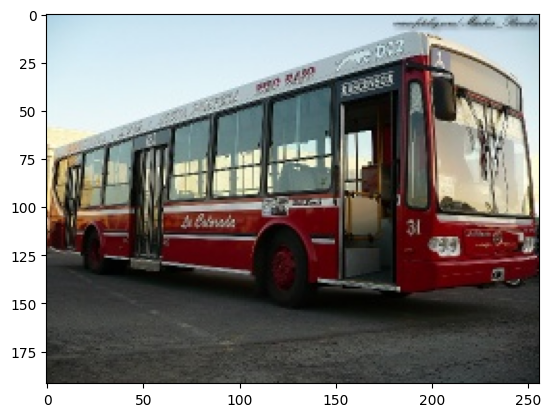

In [16]:
data_dir = '/content/data'

index = 205
file_name = os.listdir(data_dir + '/train')[index]
image = cv2.imread(os.path.join(data_dir, 'train', file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [17]:
image_id = file_name.split('.')[0]
image_id

'd6aff68bbb64a2d7'

In [18]:
# 바운딩 box는 하나가 아닐 수도 있다
meta_data = df[df['ImageID'] == image_id]
meta_data

,ImageID,LabelName,XMin,XMax,YMin,YMax
20485,d6aff68bbb64a2d7,Bus,0.0,0.998047,0.040365,0.795573


In [19]:
label = meta_data['LabelName'].values
label

array(['Bus'], dtype=object)

In [20]:
# Normalize -> 원본 크기로 변환해야 할 필요가 있다.
boxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
print(boxes, type(boxes[0]))

[[0.       0.998047 0.040365 0.795573]] <class 'numpy.ndarray'>


In [21]:
CLASS_NAME_TO_ID = {'Bus':0, 'Truck':1}
CLASS_NAME_TO_ID

{'Bus': 0, 'Truck': 1}

In [22]:
CLASS_ID_TO_NAME = {0: 'Bus', 1: 'Truck'}
CLASS_ID_TO_NAME

{0: 'Bus', 1: 'Truck'}

In [23]:
class_ids = [CLASS_NAME_TO_ID[id] for id in label]
class_ids

[0]

In [24]:
img_H, img_W, _ = image.shape

unnorm_bboxes = boxes.copy()
unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
unnorm_bboxes[:, [0,2]] *= img_W
unnorm_bboxes[:, [1,3]] *= img_H

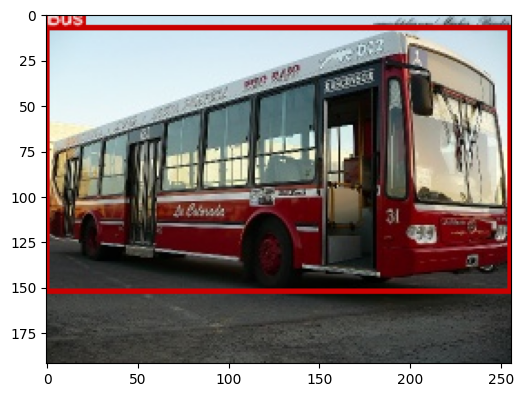

In [25]:
canvas = utils.visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [26]:
image_files = os.listdir(data_dir + '/train')

In [ ]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('/content/data/train', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_id = image_file.split('.')[0]
    meta_data = df[df['ImageID'] == image_id]
    cate_names = meta_data["LabelName"].values
    bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values

    img_H, img_W, _ = image.shape

    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
    unnorm_bboxes[:, [0,2]] *= img_W
    unnorm_bboxes[:, [1,3]] *= img_H
    canvas = utils.visualize(image, unnorm_bboxes, class_ids)

    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()
    print(canvas.shape)

### 연산을 위한 텐서 변환

1.   dataset
2.   dataloader

In [86]:
class MyDataset():
    def __init__(self, data_dir, phase, transform=None):
        self.data_dir = data_dir
        self.phase = phase
        self.df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # iamge, class_id, bounding box(xc, yc, w, h) 형식
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)

        if self.transform:
            transformed_data = transform(image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed_data['image']
            bboxes = np.array(transformed_data['bboxes'])
            class_ids = np.array(transformed_data['class_ids'])

        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        return image, target, filename

    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image

    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = self.df[self.df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])

        # 'XMin', 'XMax', 'YMin', 'YMax' -> X.center, Y.center, X.w, Y.h
        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]] # XMax, YMin 자리바꿈
        bboxes[:, 2:4] -= bboxes[:, 0:2] # XMax -> w, YMax -> h
        bboxes[:, 0:2] += bboxes[:, 2:4] / 2 # XMin -> x좌표 center, YMin -> y좌표 center
        return bboxes, class_ids

In [87]:
dataset = MyDataset(data_dir=data_dir, phase='train', transform=None)

In [88]:
image, target, filename = dataset[0]

In [89]:
image.shape

(200, 256, 3)

In [90]:
target

array([[0.52375  , 0.5896305, 0.78     , 0.812701 , 1.       ]])

In [91]:
filename

'a0e893913403c37f.jpg'

In [92]:
@interact(index=(0, len(dataset)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    img_H, img_W, _ = image.shape

    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    bboxes[:, [0,2]] *= img_W
    bboxes[:, [1,3]] *= img_H

    canvas = utils.visualize(image, bboxes, class_ids)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

In [93]:
 IMAGE_SIZE = 448

 transform = A.Compose([
                        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                        ToTensorV2()
                        ],
                       bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids'])
)

In [94]:
dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform)

In [95]:
image, target, filename = dataset[0]

In [96]:
image.shape

torch.Size([3, 448, 448])

In [97]:
target

array([[0.52375  , 0.5896305, 0.78     , 0.812701 , 1.       ]])

In [98]:
filename

'a0e893913403c37f.jpg'

In [99]:
@interact(index=(0, len(dataset)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    _, img_H, img_W = image.shape
    print(image.shape)

    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    bboxes[:, [0,2]] *= img_W
    bboxes[:, [1,3]] *= img_H

    np_image = make_grid(image, normalize=True).cpu().permute(1,2,0).numpy()
    canvas = utils.visualize(np_image, bboxes, class_ids)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=12179), Output()), _dom_classes=('widget-int…

In [100]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for i, t, f in batch:
        image_list.append(i)
        target_list.append(t)
        filename_list.append(f)

    return torch.stack(image_list, dim=0), target_list, filename_list

In [102]:
def build_dataloader(data_dir, batch_size, image_size):
    transform = A.Compose(
        [
            A.Resize(height=image_size, width=image_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ],
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids'])
    )

    dataloaders = {}

    trainset = MyDataset(data_dir, phase='train', transform=transform)
    valset = MyDataset(data_dir, phase='val', transform=transform)
    testset = MyDataset(data_dir, phase='test', transform=transform)

    dataloaders['train'] = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloaders['val'] = DataLoader(valset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    dataloaders['test'] = DataLoader(testset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    return dataloaders

In [103]:
data_dir = '/content/data'
BATCH_SIZE = 4
IMAGE_SIZE = 448

dataloaders = build_dataloader(data_dir, BATCH_SIZE, IMAGE_SIZE)

In [108]:
for phase in ["train", "val", "test"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(f'-------------{phase}--------------')
        print(images.shape)
        print(targets)
        print(filename)
        if index == 0:
            break

-------------train--------------
torch.Size([4, 3, 448, 448])
[array([[0.0728125, 0.4620595, 0.145625 , 0.363143 , 0.       ],
       [0.4140625, 0.535908 , 0.554375 , 0.743902 , 0.       ]]), array([[0.6715625, 0.343691 , 0.308125 , 0.370998 , 1.       ],
       [0.1221875, 0.3677025, 0.244375 , 0.735405 , 1.       ]]), array([[0.3828125, 0.425    , 0.121875 , 0.258888 , 1.       ],
       [0.5303125, 0.4066665, 0.086875 , 0.175555 , 1.       ],
       [0.6121875, 0.493333 , 0.076875 , 0.157778 , 1.       ]]), array([[0.1959375, 0.4750185, 0.391875 , 0.917707 , 0.       ],
       [0.511875 , 0.4915505, 0.975    , 0.950771 , 0.       ],
       [0.9109375, 0.705731 , 0.176875 , 0.587068 , 0.       ]])]
a0e893913403c37f.jpg
-------------val--------------
torch.Size([1, 3, 448, 448])
[array([[0.47625  , 0.5023495, 0.77125  , 0.668233 , 0.       ]])]
a0e893913403c37f.jpg
-------------test--------------
torch.Size([1, 3, 448, 448])
[array([[0.07125 , 0.4     , 0.1425  , 0.203362, 1.      ]]

## YOLOv1 아키텍처 구현

In [109]:
# resnet18에서 layers 부분만 backbone, (avgpool, fc)는 사용 X
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [114]:
layers = [layer for layer in resnet18.children()]
layers, len(layers)

([Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True),
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

In [115]:
test_backbone = nn.Sequential(*layers[:-2])

x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
out = test_backbone(x)
out.shape

torch.Size([1, 512, 14, 14])

In [122]:
class YOLO_RESNET(nn.Module):
    def __init__(self, num_classes):
        super(YOLO_RESNET, self).__init__()
        num_classes = num_classes
        num_bboxes = 2
        grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained=True)
        layers = [layer for layer in resnet18.children()]

        self.backbone = nn.Sequential(*layers[:-2])
        self.neck = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace=True),
        )
        self.head = nn.Sequential(
                                nn.Conv2d(in_channels=1024, out_channels=(4+1)*num_bboxes+num_classes, kernel_size=1, padding=0, bias=False),# yolo output depth
                                nn.AdaptiveAvgPool2d(output_size=(grid_size, grid_size))
        )

    def forward(self, x):
        out = self.backbone(x)
        out = self.neck(out)
        out = self.head(out) # (batch, 3, 448, 448) -> (batch, 12, 7, 7)

        return out

In [123]:
NUM_CLASSES = 2
model = YOLO_RESNET(NUM_CLASSES)
model

YOLO_RESNET(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [124]:
x = torch.randn(1, 3, 448, 448)
out = model(x)
out.shape

torch.Size([1, 12, 7, 7])

In [126]:
BATCH_SIZE = 4
model = YOLO_RESNET(num_classes=NUM_CLASSES)

for index, batch in enumerate(dataloaders['train']):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    predictions = model(images)

    print(f'input shape: {images.shape} | output shape: {predictions.shape}')

    if index == 5:
        break

input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])
input shape: torch.Size([4, 3, 448, 448]) | output shape: torch.Size([4, 12, 7, 7])


## YOLO Loss Function 구현